In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [5]:
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    image = np.array(image)
    images.append(image)
    split_var = file.split('_')
    ages.append(int(split_var[0]))
    genders.append(int(split_var[1]) )

In [6]:
len(images),len(ages),len(genders)

(23708, 23708, 23708)

In [7]:
images = pd.Series(list(images), name = 'images')
ages = pd.Series(list(ages), name = 'ages')
genders = pd.Series(list(genders), name = 'genders')

In [8]:
df = pd.concat([images, ages, genders], axis=1)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


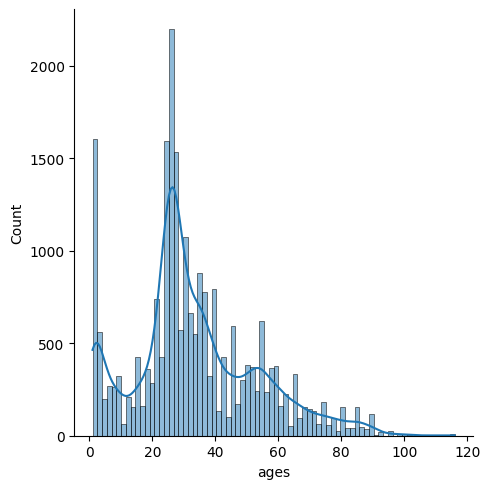

In [9]:
import seaborn as sns
sns.displot(df['ages'], kde = True)

In [10]:
# sns.displot(df['ages'], kde = True)

In [11]:
#model


In [12]:
images = df['images'].tolist()
images = np.array(images)

ages = df['ages'].tolist()
ages = np.array(ages)

genders = df['genders'].tolist()
genders = np.array(genders)


target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,images.shape[1],images.shape[2],1),dtype = 'float32')
for i in range(size):
    target[i,0] = int(ages[i])
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
# display(features[550])


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)

In [16]:
# from keras.applications.vgg16 import VGG16
# conv_model=VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))

In [17]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

2024-07-30 04:48:37.408438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 04:48:37.408559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 04:48:37.563273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [30]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [31]:
# inputs = Input(shape=(64,64,1))
# conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
# conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# x = Dropout(0.25)(pool2)
# flat = Flatten()(x)

# dropout = Dropout(0.5)

# age_model = Dense(64, activation='relu')(flat)
# age_model = dropout(age_model)
# age_model = Dense(1, activation='relu')(age_model)

# dropout = Dropout(0.5)

# gender_model = Dense(32, activation='relu')(flat)
# gender_model = dropout(gender_model)
# gender_model = Dense(1, activation='sigmoid')(gender_model)

In [36]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])

model.compile(
    optimizer='adam',
    loss={'dense_14': 'mse', 'dense_17': 'binary_crossentropy'},  # Use the correct output layer names
    metrics={'dense_14': ['mae'], 'dense_17': ['accuracy']}  # Metrics for age and gender outputs
)

# model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [37]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 62, 62,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 60, 60,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 14, 14,    │          0 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │  3,211,392 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │  3,211,392 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0],   │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_15[0][0],   │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      4,128 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dropout_7[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dropout_8[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,527,938 (24.90 MB)

 Trainable params: 6,527,938 (24.90 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
print(model.output_names)

ListWrapper(['dense_14', 'dense_17'])


In [39]:
history = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - dense_14_mae: 19.4895 - dense_17_accuracy: 0.5369 - loss: 636.8054 - val_dense_14_mae: 16.9701 - val_dense_17_accuracy: 0.6866 - val_loss: 499.0679
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - dense_14_mae: 14.5759 - dense_17_accuracy: 0.6182 - loss: 363.4575 - val_dense_14_mae: 11.1218 - val_dense_17_accuracy: 0.7680 - val_loss: 220.5900
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - dense_14_mae: 12.4199 - dense_17_accuracy: 0.6486 - loss: 269.3763 - val_dense_14_mae: 10.2245 - val_dense_17_accuracy: 0.8218 - val_loss: 190.6106
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - dense_14_mae: 11.1659 - dense_17_accuracy: 0.6701 - loss: 217.9990 - val_dense_14_mae: 8.5062 - val_dense_17_accuracy: 0.8305 - val_loss: 135.1822
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - dense_14_mae: 10.5947 - dense_17_accuracy: 0.7331 - loss: 201.6207 - val_dense_14_mae: 7.9259 - val_dense_17_accuracy: 0.8568 - val_lo

In [50]:
model.save('face.h5')

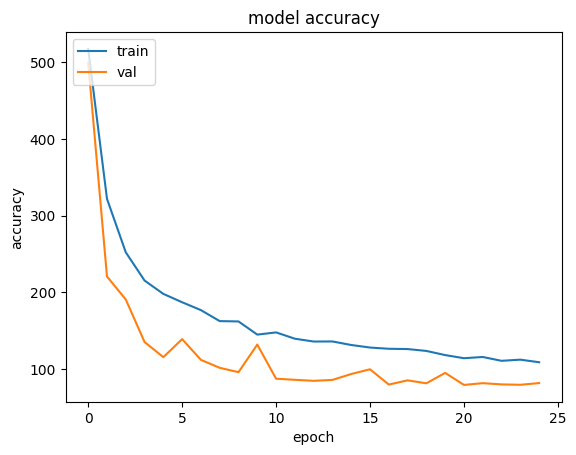

In [43]:
# history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
# k = np.expand_dims(x_test[0],axis=0)
k = x_test[0]
k.shape

(64, 64, 1)

In [47]:
model.predict(np.expand_dims(k,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[array([[24.515097]], dtype=float32), array([[0.00221406]], dtype=float32)]

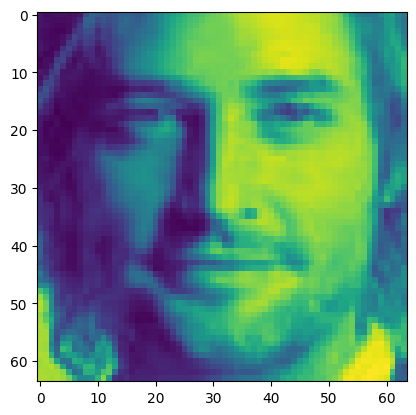

In [49]:
plt.imshow(k)